<a href="https://colab.research.google.com/github/Haoyan-L/NN-for-log-intepretation/blob/main/T2payclassification_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 安装环境

In [ ]:
!mkdir train_local
from google.colab import drive
drive.mount('/content/gdrive')
%cp -av /content/gdrive/MyDrive/ColabNotebooks/t2.zip /content/train_local
import os
os.chdir("/content/train_local")
! unzip t2.zip
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
# import tensorflow as tf
# from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers, regularizers,callbacks,Sequential
from tensorflow import optimizers
from sklearn.model_selection import train_test_split,cross_val_score,KFold,GridSearchCV 
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA, KernelPCA
from sklearn import svm
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
import pydot,graphviz 
from scipy.signal import medfilt
from sklearn.ensemble import RandomForestClassifier
from hyperopt import fmin, tpe, hp
from sklearn.metrics import confusion_matrix
from keras.metrics import sparse_categorical_crossentropy,categorical_crossentropy
import tensorflow.keras.backend as K
import warnings
warnings.filterwarnings("ignore")

def norm(a,x_min=None,x_max=None):
  if x_min is not None:
    _min=x_min
  else:
    _min=a.min(axis=0)
  if x_min is not None:
    _max=x_max
  else:
    _max=a.max(axis=0) 
  a-=_min
  a/= _max-_min    
  return a

def df_medfilt(df:pd.DataFrame,n):
    return pd.DataFrame(np.array([medfilt(df[x].values,n) for x in df.columns]).transpose(),columns=df.columns,index=df.index)

def plot_est_obs(y_data,y_pred):
  
  xx = y_data
  yy = np.argmax(y_pred,axis=1)
  res_mat=confusion_matrix(xx,yy,normalize='true')
  sns.heatmap(res_mat*100,1,vmax=100, cmap=plt.cm.Reds,square=True, annot=True)

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_' + metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation ' + metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_" + metric, 'val_' + metric])
    plt.show()

class PrintDot(callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

def roll_log(df, win=2):
    win=int(win/0.125)//8
    welllist = df.index.get_level_values(0).drop_duplicates()
    win = int(win / 0.125) + 1  # window *0.125 m
    out = []
    for w in welllist:
        sliced = []
        for i in range(0, df.shape[-1]-1):#拿掉SAND
            sliced.append(
                np.lib.stride_tricks.as_strided(
                    df.loc[w].iloc[:, i].values,
                    (len(df.loc[w]) - (win - 1), win),
                    (df.loc[w].iloc[:, i].values.strides * 2),
                )
            )
        sliced=np.array(sliced)

        if len(out) == 0:
            out = sliced
        else:
            out = np.hstack((out,sliced))
    arr=np.array(out)
    x = np.delete(arr, -1, 0).swapaxes(0, 1)
    y = arr[-1,:, int((win-1)/2 )]
    return x,y

def sample_from_df(df,group_by,sample_n, as_array=True):
  sample_df = df.groupby([group_by],as_index = False).apply(lambda x: x.sample(n=sample_n, replace=False, random_state=666))
  print(df.groupby([group_by]).size())
  # df.groupby(['CJJS']).size().plot(kind="bar")
  to_del = ['CJJS','SAND']
  if as_array:
    x=sample_df.reset_index().copy(deep=True)
    y=sample_df[group_by].reset_index().copy(deep=True)
    x.drop(['level_0','WELL','DEPT']+to_del, axis=1,inplace=True)
    y.drop(['level_0','WELL','DEPT'], axis=1,inplace=True)
    x=np.array(x)
    y=np.array(y)[:,0]
  else:
    x=sample_df.copy(deep=True)
    x.drop(to_del , axis=1,inplace=True)
    y=sample_df[group_by]
  return x,y

  
def reverse_norm(data,x_min,x_max):
    df_data=pd.DataFrame(data,columns=log_list[0:-1])
    l=data.shape[-1]
    x_min=x_min[0:l]
    x_max=x_max[0:l]
    return df_data*(x_max-x_min)+x_min

def locate_log(data,df,d=15):
    
    d_AC,d_CNL,d_DEN,d_PE,d_RT,d_SH,d_SP = data
    tar=df.query("AC == @d_AC and CNL == @d_CNL and DEN == @d_DEN and PE == @d_PE and RT == @d_RT and SH == @d_SH and SP == @d_SP").index.tolist()
    if len(tar)>1:
        print(tar)
        print('selected the first line as result')
        tar=tar[0]
    wn=tar[0][0]
    depth=tar[0][-1]
    out=df.query("WELL== @wn and DEPT>= @depth -@d and DEPT<=@depth + @d")
    # print_log(out,x_min,x_max)
    return out

def plot_track(log_df,log_n,style,ops=None,is_first=False,add=False):
    if add==True:
        plt.twiny()
    d=log_df.index.get_level_values('DEPT')
    xx=log_df[log_n]
    dmax=np.max(xx)
    dmin=np.min(xx)
    dd=dmax-dmin
    if ops=="log":
        xx=10**xx
        dmin=10**int(dmin)
        dmax=10**(int(dmax)+1)
        dd=np.log10(dmax/dmin)
        x_ticks=np.logspace(np.log10(dmin),np.log10(dmax),int(dd)+1)
        x_ticks_label=['%.0E'%x for x in x_ticks]
        plt.plot(xx,d,style)
        plt.xscale("log")
    else:
        plt.plot(xx,d,style) 
        x_ticks=(np.linspace(dmin,dmax,6))
        x_ticks_label=[None,round(dmin+0.2*dd,1),round(dmin+0.4*dd,1),round(dmin+0.6*dd,1),round(dmin+0.8*dd,1),None]
    plt.xticks(x_ticks,x_ticks_label)
    plt.xlabel(log_n)
    ax=plt.gca()
    ax.grid()

    if ops =='reverse':
        ax.invert_xaxis()
  
    if add ==True:
        # plt.setp(ax.get_xmajorticklabels(), visible=False)
        pass
    else:
        ax.invert_yaxis()
    
    if not is_first:
        plt.setp(ax.get_ymajorticklabels(), visible=False)
    
    
    plt.hlines(y=d[int(log_df.shape[0]/2+0.5)],xmin=dmin, xmax=dmax, colors='k',linewidth=3)

def plot_log(log_df):
    fig=plt.figure(figsize=(10,20))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None,wspace=0, hspace=0.5)
    fig.add_subplot(141)
    plot_track(log_df,'SH','r-',is_first=True)    
    fig.add_subplot(142)
    plot_track(log_df,'DEN','k--',ops="reverse")                                                                                              
    plot_track(log_df,'CNL','b--',add=True)
    fig.add_subplot(143)
    plot_track(log_df,'AC','b-')
    fig.add_subplot(144)
    plot_track(log_df,'RT','g-',ops="log")


Mounted at /content/gdrive
'/content/gdrive/MyDrive/ColabNotebooks/t2.zip' -> '/content/train_local/t2.zip'
Archive:  t2.zip
  inflating: jl.xlsx                 
  inflating: T2logs.csv              


# I 数据预处理

### 1数据读取


In [ ]:
fn=r'T2logs.csv'
dtype = {
    "DEPT": np.float64,
    "AC": np.float64,
    "CNL": np.float64,
    "DEN": np.float64,
    "GR": np.float64,
    "PERM": np.float64,
    "POR": np.float64,
    "PE": np.float64,
    "RT": np.float64,
    "SP": np.float64,
    "SH": np.float64,
    "SW": np.float64,
    "TVD":np.float64
}
df = pd.read_csv(fn, index_col=[0,1], header=0,dtype=dtype)
df=df[df['TVD']>2000]
#整理修复个别井问题
df.loc[['Tao2-33-2',],'AC']=df.loc[['Tao2-33-2',],'AC'].values*3.28081 #AC多除了
df.loc[['Tao2-32-9',],'AC']=df.loc[['Tao2-32-9',],'AC'].values/3.28081
df.loc[['Tao2-32-9',],'PORT']=df.loc[['Tao2-32-9',],'PORT'].values/100
df.loc[['Tao2-32-9',],'SW']=df.loc[['Tao2-32-9',],'SW'].values/100
for w in ['Tao2-32-6', 'Tao2-32-7', 'Tao2-32-8', 'Tao2-33-10', 'Tao2-33-7C3', 'Tao2-33-9', 'Tao2-32-9']:
    df.loc[[w,],'SH']=df.loc[[w,],'SH'].values/100
df.replace(-999.25,np.nan,inplace=True)
df.replace(-99999,np.nan,inplace=True)
df['AC'].replace(0,np.nan,inplace=True)
df['DEN'].replace(0,np.nan,inplace=True)
df['PE'].replace(0,np.nan,inplace=True)
df['RT']=df['RT'].apply(lambda x: max(-5,np.log10(x)))
df['PERM']=df['PERM'].apply(lambda x: max(-5,np.log10(x)))
df['CJJS']=9

#读取测井解释结论
# rpf=pp.ProfileReport(df)
fn_jl=r'jl.xlsx'
jl=pd.read_excel(fn_jl,sheet_name='SLB',header=0,index_col=None)
jl2=pd.read_excel(fn_jl,sheet_name='PCOC',header=0,index_col=None)

SLB_wells=jl['WELL'].drop_duplicates()
PCOC_wells=jl2['WELL'].drop_duplicates()

ALL_wells=pd.concat([SLB_wells,PCOC_wells],axis=0)
df=df.loc[(ALL_wells,),:]#去掉了没有的井
dict_zone={
    '干层':3,
    '水层':2,
    '含气水层':2,
    '气水同层':1,
    '差气层':1,
    '气层':0
}
dim=len(set(dict_zone.values()))
jl['JL']=jl['JL'].map(dict_zone)
jl2['JL']=jl2['JL'].map(dict_zone)
jl_all=pd.concat([jl,jl2],axis=0)


#测井解释赋值
for t in jl_all.itertuples():
    well=t[1]
    top=t[2]
    bot=t[3]
    res=t[4]
    ind=df.query("WELL == @well and DEPT > @top and DEPT < @bot").index
    df.loc[ind,'CJJS']=res
#替换掉负值
for c in  df.columns.difference(['PERM','RT']):
    v=0 if c!='SP' else -9
    ind=df[df[c]<v].index
    df.drop(ind,inplace=True)
log_list=['AC','CNL','DEN','PE','RT','SH','SP','CJJS']
df=df[log_list]
# log_list=['AC','CNL','DEN','GR','PERM','PE','PORT','RT','SW','SH','SP']
#定义砂体-非砂体解释   
df['SAND']=np.nan
df['SAND'][df['CJJS']<9]=1
df['SAND'][df['CJJS']==9]=0
df.dropna(how='any',axis=0,inplace=True)#除掉

# df=df[df['CJJS']<9]#不要非砂体
df.iloc[:,0:-2]=df_medfilt(df.iloc[:,0:-1],3) #滤波
x_max=df[df['CJJS']<9].max(axis=0)
x_min=df[df['CJJS']<9].min(axis=0)
df.iloc[:,0:-2]=norm(df.iloc[:,0:-1],x_min,x_max) #标准化
print(pd.concat([x_min,x_max],axis=1))

              0           1
AC    44.940000  104.960000
CNL    1.036600   52.243800
DEN    1.727600    2.892500
PE     1.310000    5.160000
RT     0.757927    3.363966
SH     0.011300    0.999000
SP    -8.920000  112.890000
CJJS   0.000000    3.000000
SAND   1.000000    1.000000


## 2.数据处理

In [ ]:
x_pre_data,y_pre_data=sample_from_df(df,'SAND',14000)
x_pre_train, x_pre_test , y_pre_train, y_pre_test = train_test_split(x_pre_data, y_pre_data, test_size = 0.25)
sample_n=500
x_data,y_data=sample_from_df(df.loc[(SLB_wells,),:],'CJJS',sample_n)
x_data=x_data[0:-sample_n,:]
y_data=y_data[0:-sample_n]

x_train, x_test , y_train, y_test = train_test_split(x_data, y_data, test_size = 0.25)
# x_PCOC,y_PCOC=sample_from_df(df.loc[(PCOC_wells,),:],'CJJS',500)

SAND
0.0    70211
1.0    14402
dtype: int64
CJJS
0      510
1      531
2     1130
3     3769
9    28447
dtype: int64


选择测井维度较大，采用PCA进行降维。


The Varaince Ratios are:

[0.35620424 0.28911089 0.18402326 0.08639792 0.04660942]
PC matrix:
	AC	CNL	DEN	PE	RT	SH	SP	CJJS


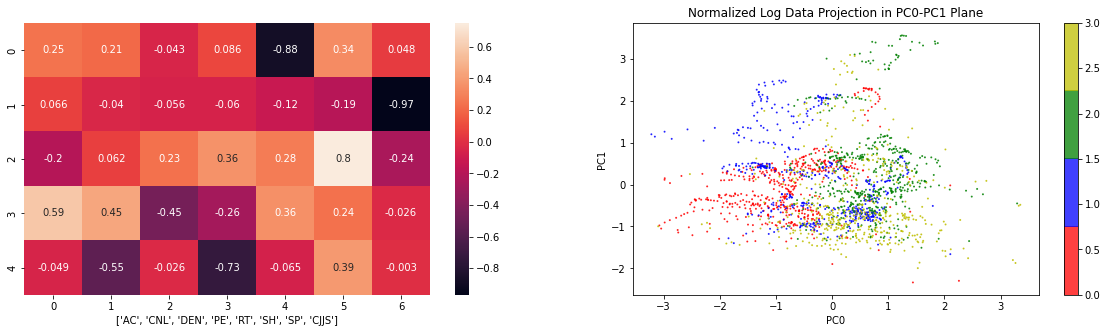

In [ ]:
# # PCA
fig=plt.figure(figsize=(20,5))
fig.add_subplot(121)
pca = PCA(n_components=0.95,whiten=True)
x_data_PCA =pca.fit_transform(x_data)
print('The Varaince Ratios are:\n')
print(pca.explained_variance_ratio_)
print('PC matrix:\n\t'+"\t".join(log_list))
sns.heatmap(pca.components_, vmax=0.75, square=False, annot=True)
plt.xlabel(log_list)
cmap=mpl.colors.ListedColormap(['r','b','g','y','k','cyan','magenta'],'indexed')
cmap1=mpl.colors.ListedColormap(['r','b','g','y'],'indexed')
fig.add_subplot(122)
plt.scatter(x_data_PCA[:, 0], x_data_PCA[:, 1],s=1,alpha=0.75, c=y_data,cmap=cmap1)
plt.title('Normalized Log Data Projection in PC0-PC1 Plane')
plt.xlabel('PC0')
plt.ylabel('PC1')
plt.colorbar()

# II 砂体/非砂体模型

In [ ]:
param_test1= {'n_estimators':range(20,60,10),'max_depth':range(4,14,2)}
gsearch1= GridSearchCV(estimator = RandomForestClassifier(min_samples_split=10,
                                 min_samples_leaf=20,random_state=10),
                       param_grid =param_test1, scoring='accuracy',cv=5)
gsearch1.fit(x_pre_data,y_pre_data)
print(gsearch1.best_params_, gsearch1.best_score_)

{'max_depth': 12, 'n_estimators': 50} 0.9377857142857142


Accuracy:

[0.93357143 0.93614286 0.93628571 0.938     ], average 0.936


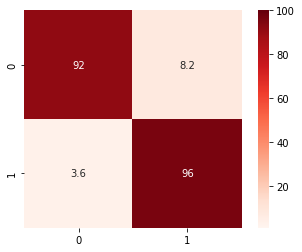

In [ ]:
rf_pre=RandomForestClassifier(n_estimators=30,min_samples_split=10,
                                 min_samples_leaf=20,max_depth=10,random_state=10)
rf_pre.fit(x_pre_train,y_pre_train)
y_predict=rf_pre.predict_proba(x_pre_data)
plot_est_obs(y_pre_data,y_predict)
print('Accuracy:\n')
scores=cross_val_score(rf_pre, x_pre_data, y_pre_data, cv=4, scoring='accuracy')
print('%s, average %.3f' %(scores,scores.mean()))

# III 有监督学习

### 1.KNN


对KNN中的K进行调参，K大了反而不好

Text(0, 0.5, 'Error')

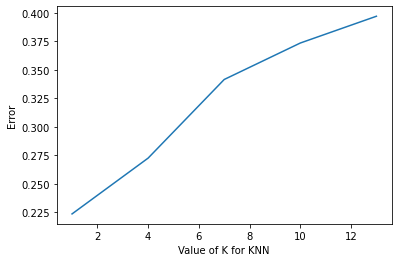

In [ ]:
# KNN k取值最优
k_range = range(1, 15,3)
k_error = []
#循环，取k=1到k=31，查看误差效果
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k,weights='distance')
    scores = cross_val_score(knn, x_data, y_data, cv=5, scoring='accuracy')
    k_error.append(1-scores.mean())
plt.plot(k_range, k_error)
plt.xlabel('Value of K for KNN')
plt.ylabel('Error')

Accuracy:

[0.79 0.75 0.82 0.85 0.84], average 0.810


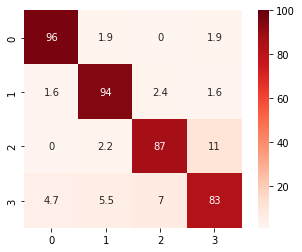

In [ ]:
# KNN
knn = KNeighborsClassifier(n_neighbors=3,weights='distance')
knn.fit(x_train, y_train)
y_predict=knn.predict_proba(x_test)
plot_est_obs(y_test,y_predict)
print('Accuracy:\n')
scores=cross_val_score(knn, x_test, y_test, cv=5, scoring='accuracy')
print('%s, average %.3f' %(scores,scores.mean()))



### 2.SVM算法

SVM结果类似，但表现不如KNN,算力消耗较大。使用rbf核函数效果好于其它。

Accuracy:

[0.792 0.814 0.806 0.814], average 0.806


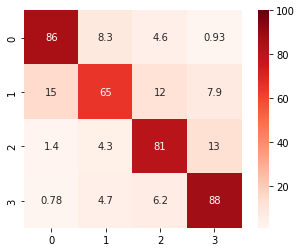

In [ ]:
#SVM
sv = svm.SVC(kernel='poly',probability=True)
sv.fit(x_train,y_train)
y_predict = sv.predict_proba(x_test)
plot_est_obs(y_test,y_predict)
print('Accuracy:\n')
scores=cross_val_score(sv, x_data, y_data, cv=4, scoring='accuracy')
print('%s, average %.3f' %(scores,scores.mean()))

##  3.决策树Decision Tree

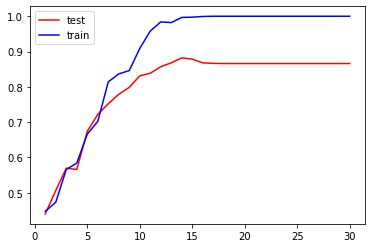

In [ ]:
train=[]
test = [] 
num=30
for i in range(num):
    clf = DecisionTreeClassifier(max_depth=i+1
                                          ,criterion="entropy"                                      
                                          ,random_state=666                                      
                                          ,splitter="random"                                     
                                          )
    clf = clf.fit(x_train, y_train)
    score_tr = clf.score(x_train,y_train)
    score_te = cross_val_score(clf,x_data,y_data,cv=5).mean()
    test.append(score_te)
    train.append(score_tr) 
plt.plot(range(1,num+1),test,color="red",label="test") 
plt.plot(range(1,num+1),train,color="b",label="train") 
plt.legend() 


In [ ]:

parameters = {          
              "max_depth":[*range(1,10)]              
              ,'min_samples_leaf':[*np.linspace(0.001,0.05,10)]              
              ,'min_samples_split':[*np.linspace(0.001,0.05,10)]             
              }

clf = DecisionTreeClassifier(random_state=666) 
GS = GridSearchCV(clf, parameters, cv=4) 
GS.fit(x_train,y_train)
 
GS.best_params_

{'max_depth': 9, 'min_samples_leaf': 0.001, 'min_samples_split': 0.001}

Train score:0.862
Test score:0.756
Accuracy:

[0.76  0.748 0.762 0.78 ], average 0.762


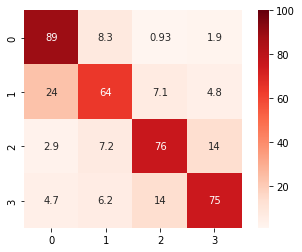

In [ ]:
#Tree
tree = DecisionTreeClassifier(
    max_depth=9,
    random_state=666,
    criterion="entropy",
    splitter="random",
    min_samples_leaf= 0.001,
    min_samples_split=0.001
    )
tree.fit(x_train,y_train)
print('Train score:{:.3f}'.format(tree.score(x_train,y_train)))
print('Test score:{:.3f}'.format(tree.score(x_test,y_test)))

#生成可视化图
# dot_data=export_graphviz(tree,out_file=None,class_names=['0','1','2','3','4'],feature_names=feature_name,impurity=True,filled=True)
#展示可视化图
# graph = graphviz.Source(dot_data) 
# graph
y_predict = tree.predict_proba(x_test)
plot_est_obs(y_test,y_predict)
print('Accuracy:\n')
scores=cross_val_score(tree, x_data, y_data, cv=4, scoring='accuracy')
print('%s, average %.3f' %(scores,scores.mean()))

## 4.随机森林

In [ ]:
param_test1= {'n_estimators':range(40,90,20)}
gsearch1= GridSearchCV(estimator = RandomForestClassifier(min_samples_split=10,
                                 min_samples_leaf=20,max_depth=8,random_state=10),
                       param_grid =param_test1, scoring='accuracy',cv=5)
gsearch1.fit(x_data,y_data)
print(gsearch1.best_params_, gsearch1.best_score_)


{'n_estimators': 80} 0.3215


In [ ]:
param_test2= {'max_depth':range(4,11,2), 'min_samples_split':np.linspace(0.005,0.05,10)}
gsearch2= GridSearchCV(estimator = RandomForestClassifier(n_estimators= 80,
                                 min_samples_leaf=0.005,random_state=10),
                        param_grid = param_test2,scoring='accuracy', cv=5)
gsearch2.fit(x_data,y_data)
print(gsearch2.best_params_, gsearch2.best_score_)



{'max_depth': 10, 'min_samples_split': 0.005} 0.466


Accuracy:

[0.838 0.83  0.846 0.854], average 0.842


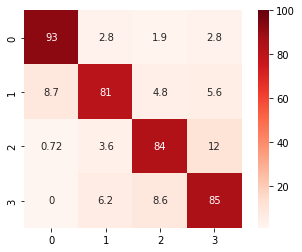

In [ ]:
rf=RandomForestClassifier(n_estimators= 80,max_depth=10,min_samples_leaf=0.001, min_samples_split=0.01,max_features='sqrt' ,oob_score=True, random_state=10)
rf.fit(x_train,y_train)
y_predict=rf.predict_proba(x_test)
plot_est_obs(y_test,y_predict)
print('Accuracy:\n')
scores=cross_val_score(rf, x_data, y_data, cv=4, scoring='accuracy')
print('%s, average %.3f' %(scores,scores.mean()))

# IV  使用神经网络学习

In [ ]:
#执行一次
y_data=K.one_hot(y_data,dim).numpy()
y_train=K.one_hot(y_train,dim).numpy()
y_test=K.one_hot(y_test,dim).numpy()

In [ ]:

def simpleNN(neuron1,neuron2,loss='categorical_crossentropy'):
    dp_rate = 0.25
    
    l1_coef,l2_coef=[0.0001,0.0001]
    neuron1=int(neuron1)
    neuron2=int(neuron2)
    model = tf.keras.Sequential()
    model.add(layers.Dense(neuron1, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=l1_coef, l2=l2_coef), input_shape=(x_data.shape[1], )))
    model.add(layers.Dropout(dp_rate))
    model.add(layers.Dense(neuron2, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=l1_coef, l2=l2_coef)))
    model.add(layers.Dense(dim,activation='softmax'))
    opt=tf.optimizers.RMSprop()
    # opt=optimizers.Adam(decay=1e-3)
    model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])
    return model

def kfold_val(neuron1,neuron2,bs,callbacks_list,loss='categorical_crossentropy'):
    
    fold_no = 1
    acc_per_fold = []
    loss_per_fold = []
    epochs = 200
    batchsize=int(2**bs)

    
    for train, test in kfold.split(x_data, y_data):
        model = simpleNN(neuron1,neuron2,loss=loss)
        history = model.fit(x_data[train], y_data[train], 
                            validation_data=(x_data[test], y_data[test]), 
                            epochs=epochs,
                            batch_size=batchsize,
                            verbose=0,
                            callbacks=callbacks_list
                        )
        scores =  history.history['val_accuracy']
        acc_per_fold.append(scores[-1])
        loss_per_fold.append(scores[0])
        # Increase fold number
        fold_no = fold_no + 1
    print([neuron1,neuron2,bs,round(np.mean(acc_per_fold),3)])
    return 1-np.mean(acc_per_fold)

def simple_train(ep,bs,mdl,x_train,y_train, x_test,y_test,cbl):
  epochs = ep
  batchsize=2**bs
  history = mdl.fit(x_train, y_train, 
                      validation_data=(x_test, y_test), 
                      epochs=epochs, 
                      batch_size=batchsize,
                      verbose=0,
                      callbacks=cbl
                  )
  return mdl,history

def CNN(win,ker,loss='categorical_crossentropy'):
    ker=int(ker)
    fil=((8*win+1)//ker)*7
    dp=0.2
    den=12
    model = Sequential()
    # model2.add(layers.LSTM(24,dropout=0.2,recurrent_dropout=0.2,))
    model.add(layers.Conv1D(input_shape=(8*win+1,x_data.shape[-1]),filters=fil, kernel_size=ker ,padding="valid", activation="relu"))
    model.add(layers.Conv1D(filters=fil, kernel_size=ker ,padding="valid", activation="relu"))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Dropout(dp))
    model.add(layers.Conv1D(filters=fil*2, kernel_size=ker//2 ,padding="valid", activation="relu"))
    model.add(layers.Conv1D(filters=fil*2, kernel_size=ker//2 ,padding="valid", activation="relu"))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Dropout(dp))
    model.add(layers.Conv1D(filters=fil*4, kernel_size=max(2,ker//4) ,padding="valid", activation="relu"))
    model.add(layers.GlobalAveragePooling1D())
    model.add(layers.Dropout(dp))
    model.add(layers.Dense(den, activation="relu"))
    model.add(layers.Dense(dim, activation="softmax"))
    # 开始训练
    opt=optimizers.Adam(decay=1e-3)
    model.compile(loss=loss, optimizer=opt, metrics=["accuracy"], )
    return model


def kfold_val_CNN(win,ker,bs,callbacks_list,loss='categorical_crossentropy'):
  win=int(win)
  bs=int(2**bs)
  x_data_CNN, y_data_CNN = roll_log(df.loc[(SLB_wells,),:], win)

  # 分组抽样
  # x_data_CNN.shape
  sample_y=pd.DataFrame(y_data_CNN,columns=['CJJS'])
  sample_y=sample_y[sample_y['CJJS']<9]
  sample_y.groupby(['CJJS'],as_index = False).apply(lambda x: x.sample(n=sample_n, replace=False, random_state=666))
  index = sample_y.index.get_level_values(0)
  x_data_CNN =x_data_CNN[index]
  x_data_CNN = x_data_CNN.swapaxes(1,2)
  y_data_CNN = y_data_CNN[index]
  y_data_CNN= K.one_hot(y_data_CNN,dim).numpy()
  acc_per_fold = []
  loss_per_fold = []
  epochs = 150
  batchsize = bs
  # print(ker)
  for train, test in kfold.split(x_data_CNN, y_data_CNN):
      model = CNN(win,ker,loss=loss)
      history=model.fit(
          x_data_CNN[train],
          y_data_CNN[train],
          validation_data=(x_data_CNN[test], y_data_CNN[test]),
          epochs=epochs,
          batch_size=batchsize,
          verbose=0,
          callbacks=callbacks_list,
      )
      scores =  history.history['val_accuracy']
      acc_per_fold.append(scores[-1])
      # Increase fold number
      # fold_no = fold_no + 1
  print('w=%1d, ker= %1d batch_size=%d  accuracy=%3f\n ' % (win,ker,bs,np.mean(acc_per_fold)))
  return 1-np.mean(acc_per_fold)


### 1.简单全连接

In [ ]:
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5)
lr_adjust=callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.3,patience=3)
callbacks_list = [early_stop, lr_adjust]
num_folds =4
kfold = KFold(n_splits=num_folds, shuffle=True)
def f(args):
    neuron1,neuron2,bs = args 
    return kfold_val(neuron1,neuron2,bs,callbacks_list)

fspace = [
    hp.quniform('neuron1', 32,65,8),
    hp.quniform('neuron2', 18, 25,2),
    hp.quniform('bs', 4, 7,1),
]
best = fmin(fn=f, space=fspace, algo=tpe.suggest, max_evals=15)
print('best match',best)


[40.0, 18.0, 6.0, 0.717]
[56.0, 20.0, 4.0, 0.72]
[40.0, 18.0, 5.0, 0.716]
[56.0, 20.0, 6.0, 0.735]
[48.0, 20.0, 6.0, 0.717]
[40.0, 20.0, 6.0, 0.697]
[64.0, 22.0, 7.0, 0.727]
[56.0, 24.0, 4.0, 0.721]
[48.0, 18.0, 7.0, 0.737]
[56.0, 18.0, 7.0, 0.722]
[40.0, 18.0, 6.0, 0.718]
[40.0, 24.0, 5.0, 0.716]
[40.0, 24.0, 6.0, 0.725]
[48.0, 22.0, 7.0, 0.717]
[48.0, 22.0, 5.0, 0.733]
100%|██████████| 15/15 [16:13<00:00, 64.88s/it, best loss: 0.2630000114440918]
best match {'bs': 7.0, 'neuron1': 48.0, 'neuron2': 18.0}



.....................................................................................Accuracy is 0.722000


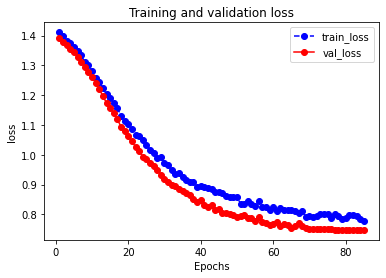

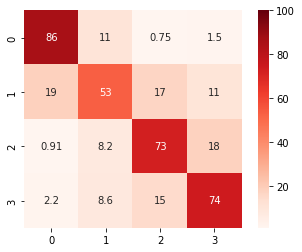

In [ ]:
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5)
lr_adjust=callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.3,patience=3)
callbacks_list = [early_stop, lr_adjust,PrintDot()]
model_dense=simpleNN(48,18)
model_dense,history=simple_train(200,7,model_dense,x_train,y_train, x_test,y_test,callbacks_list)
scores =  history.history['val_accuracy']
print('Accuracy is %1f' %  scores[-1] )
plot_metric(history,'loss')
plot_est_obs(np.argmax(y_test,axis=1),model_dense.predict(x_test))

1 2


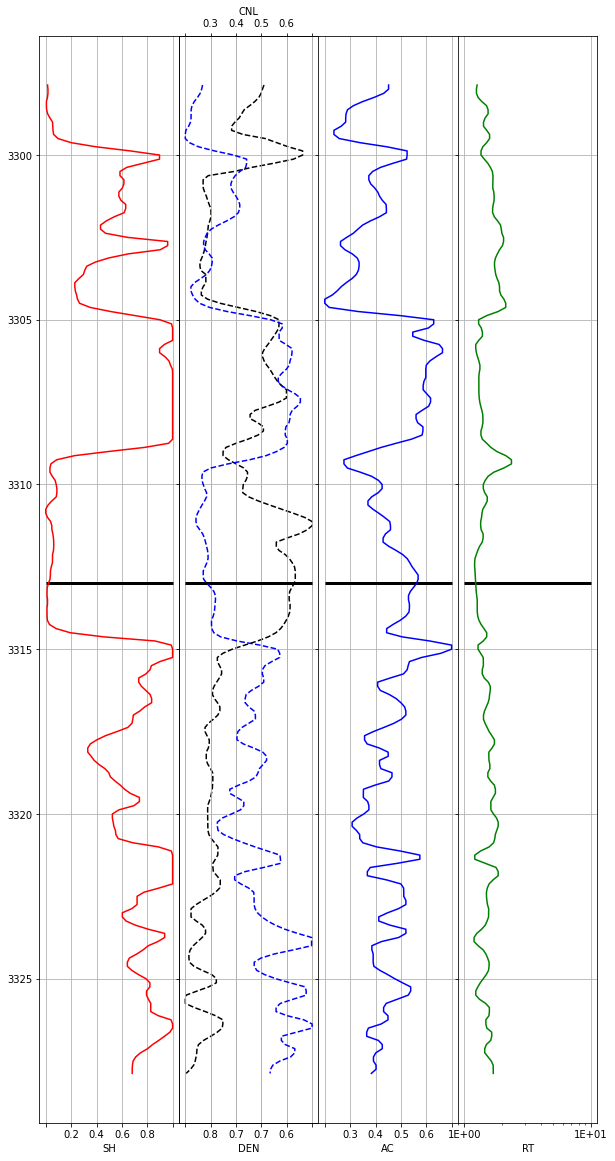

In [ ]:
k=1288
print(np.argmax(y_train[k]),np.argmax(model_dense.predict(x_train)[k]))
log_df=locate_log(x_train[k],df)
plot_log(log_df)


### 2.一维卷积网络



使用一维卷积网络训练。首先按照深度生成连续的测井序列.使用conv1D在不同的窗口时长下，训练模型。效果有明显提高，代价很大。主要原因疑似是标签中0和1重合度太高，因此需要精细


解释为ground truth标签，在用神经网络的话效果就会好

w=16, ker= 9 batch_size=128  accuracy=0.946128
 
w=12, ker= 17 batch_size=256  accuracy=0.971044
 
w=16, ker= 12 batch_size=256  accuracy=0.949832
 
w=14, ker= 18 batch_size=256  accuracy=0.975926
 
w=16, ker= 14 batch_size=64  accuracy=0.976094
 
w=14, ker= 11 batch_size=128  accuracy=0.964815
 
w=16, ker= 19 batch_size=64  accuracy=0.972054
 
w=16, ker= 16 batch_size=256  accuracy=0.972896
 
w=12, ker= 20 batch_size=128  accuracy=0.982828
 
w=16, ker= 11 batch_size=64  accuracy=0.954040

w=8, ker= 14 batch_size=256  accuracy=0.982492
 
w=8, ker= 10 batch_size=512  accuracy=0.966162

w=8, ker= 12 batch_size=128  accuracy=0.980303
 
w=6, ker= 8 batch_size=256  accuracy=0.976094
w=10, ker= 10 batch_size=512  accuracy=0.944108
 
w=8, ker= 6 batch_size=512  accuracy=0.946801
 
w=10, ker= 6 batch_size=512  accuracy=0.920202
 
w=8, ker= 8 batch_size=256  accuracy=0.965657
 
w=10, ker= 8 batch_size=512  accuracy=0.924411
 
w=10, ker= 8 batch_size=128  accuracy=0.956397
 
w=8, ker= 8 batch_size=512  accuracy=0.954209
 
w=10, ker= 12 batch_size=256  accuracy=0.963973
 
w=8, ker= 8 batch_size=128  accuracy=0.967677
 
w=10, ker= 10 batch_size=256  accuracy=0.956902
 
w=10, ker= 12 batch_size=256  accuracy=0.962290
 
w=8, ker= 8 batch_size=512  accuracy=0.959091
 
w=10, ker= 6 batch_size=256  accuracy=0.935522
 
w=10, ker= 8 batch_size=128  accuracy=0.956229
 
w=8, ker= 12 batch_size=256  accuracy=0.967845
 
w=8, ker= 6 batch_size=512  accuracy=0.943098
 
w=10, ker= 10 batch_size=256  accuracy=0.961111
 
w=8, ker= 8 batch_size=512  accuracy=0.947475
 
w=8, ker= 10 batch_size=256  accuracy=0.968687
 
w=10, ker= 10 batch_size=512  accuracy=0.940404
w=10, ker= 10 batch_size=128  accuracy=0.971549
 
w=10, ker= 12 batch_size=128  accuracy=0.973232
 
w=8, ker= 12 batch_size=128  accuracy=0.980976
 
w=10, ker= 12 batch_size=64  accuracy=0.972391
 
w=10, ker= 12 batch_size=64  accuracy=0.973737
 
w=8, ker= 12 batch_size=128  accuracy=0.977946
 
w=8, ker= 12 batch_size=128  accuracy=0.979966
 
w=8, ker= 10 batch_size=128  accuracy=0.966667
 
w=10, ker= 12 batch_size=64  accuracy=0.977609
 
w=8, ker= 12 batch_size=128  accuracy=0.975084
 
w=10, ker= 12 batch_size=256  accuracy=0.960774
 
w=10, ker= 12 batch_size=64  accuracy=0.980303
 
w=8, ker= 12 batch_size=128  accuracy=0.978620
 
w=10, ker= 12 batch_size=256  accuracy=0.967340
 
w=8, ker= 10 batch_size=256  accuracy=0.967172
 
w=10, ker= 12 batch_size=256  accuracy=0.968013
 
w=8, ker= 10 batch_size=64  accuracy=0.975421
 
w=10, ker= 12 batch_size=128  accuracy=0.973737
 
w=10, ker= 10 batch_size=128  accuracy=0.965488
 
w=8, ker= 12 batch_size=128  accuracy=0.981481
w=14, ker= 20 batch_size=64  accuracy=0.981650
 
w=12, ker= 20 batch_size=64  accuracy=0.980135
 
w=14, ker= 16 batch_size=128  accuracy=0.977273
 
w=16, ker= 20 batch_size=128  accuracy=0.971886
 
w=14, ker= 18 batch_size=256  accuracy=0.966498
 
w=18, ker= 20 batch_size=128  accuracy=0.974411
 
w=16, ker= 16 batch_size=256  accuracy=0.960269
 
w=16, ker= 20 batch_size=128  accuracy=0.973906
 
w=16, ker= 16 batch_size=128  accuracy=0.964983
 
w=14, ker= 18 batch_size=128  accuracy=0.970370
 
w=12, ker= 20 batch_size=128  accuracy=0.979630
 
w=16, ker= 20 batch_size=128  accuracy=0.969865
 
w=16, ker= 14 batch_size=128  accuracy=0.967845
 
w=14, ker= 20 batch_size=64  accuracy=0.976768
 
w=14, ker= 16 batch_size=256  accuracy=0.967172
 
w=14, ker= 16 batch_size=64  accuracy=0.973569
 
w=12, ker= 14 batch_size=128  accuracy=0.969192
 
w=16, ker= 14 batch_size=128  accuracy=0.965993
 
w=12, ker= 18 batch_size=64  accuracy=0.980808
 
w=14, ker= 16 batch_size=128  accuracy=0.969697
w=16, ker= 22 batch_size=128  accuracy=0.972391
 
w=18, ker= 24 batch_size=256  accuracy=0.966498
 
w=16, ker= 20 batch_size=128  accuracy=0.972391
 
w=16, ker= 18 batch_size=128  accuracy=0.969529
 
w=16, ker= 18 batch_size=64  accuracy=0.977104
 
w=16, ker= 22 batch_size=128  accuracy=0.972727
 
w=18, ker= 20 batch_size=128  accuracy=0.968687
 
w=16, ker= 20 batch_size=128  accuracy=0.975589

In [ ]:
early_stop = callbacks.EarlyStopping(monitor="val_loss", patience=8,min_delta=0.001)
lr_adjust = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=4)
# tb = keras.callbacks.TensorBoard(log_dir='log',histogram_freq=2)
callbacks_list = [early_stop, lr_adjust]
num_folds =4
kfold = KFold(n_splits=num_folds, shuffle=True)
def f(args):
    win,ker,bs = args 
    return kfold_val_CNN(win,ker,bs,callbacks_list)

fspace = [
    hp.quniform('win',12,18,2),
    hp.quniform('ker',14,20,2),
    hp.quniform('bs',6,8,1),
]
best = fmin(fn=f, space=fspace, algo=tpe.suggest, max_evals=20)
print('best match',best)

w=12, ker= 18 batch_size=128  accuracy=0.981145
 
w=12, ker= 16 batch_size=128  accuracy=0.975758
 
w=18, ker= 16 batch_size=128  accuracy=0.960606
 
w=12, ker= 16 batch_size=64  accuracy=0.980808
 
w=18, ker= 18 batch_size=128  accuracy=0.962121
 
w=14, ker= 20 batch_size=256  accuracy=0.965320
 
w=14, ker= 18 batch_size=128  accuracy=0.974074
 
w=16, ker= 18 batch_size=64  accuracy=0.976431
 
w=14, ker= 18 batch_size=128  accuracy=0.968855
 
w=18, ker= 18 batch_size=256  accuracy=0.962458
 
 50%|█████     | 10/20 [5:28:17<6:19:11, 2275.12s/it, best loss: 0.018855229020118713]

In [ ]:
win=6
ker=10
x_data_CNN, y_data_CNN = roll_log(df.loc[(SLB_wells,),:], win)

# 分组抽样
# x_data_CNN.shape
sample_y=pd.DataFrame(y_data_CNN,columns=['CJJS'])
sample_y=sample_y[sample_y['CJJS']<9]
sample_y.groupby(['CJJS'],as_index = False).apply(lambda x: x.sample(n=sample_n, replace=False, random_state=666))
index = sample_y.index.get_level_values(0)
x_data_CNN =x_data_CNN[index]
x_data_CNN = x_data_CNN.swapaxes(1,2)
y_data_CNN = y_data_CNN[index]
y_data_CNN= K.one_hot(y_data_CNN,dim).numpy()
x_train_CNN, x_test_CNN , y_train_CNN, y_test_CNN = train_test_split(x_data_CNN, y_data_CNN, test_size = 0.25)

early_stop = callbacks.EarlyStopping(monitor="val_loss", patience=8,min_delta=0.001)
lr_adjust = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=4)
# tb = keras.callbacks.TensorBoard(log_dir='log',histogram_freq=2)
callbacks_list = [early_stop, lr_adjust,PrintDot()]

model_CNN = CNN(win,ker)
model_CNN,history=simple_train(150,7,model_CNN,x_train_CNN,y_train_CNN,x_test_CNN,y_test_CNN,callbacks_list)
scores =  history.history['val_accuracy'][-1]
print(scores)
plot_metric(history,'accuracy')
plot_est_obs(np.argmax(y_test_CNN,axis=1),model_CNN.predict(x_test_CNN))


KeyboardInterrupt: ignored

In [ ]:
model_CNN.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_88 (Conv1D)          (None, 40, 42)            2982      
                                                                 
 conv1d_89 (Conv1D)          (None, 31, 42)            17682     
                                                                 
 max_pooling1d_34 (MaxPoolin  (None, 15, 42)           0         
 g1D)                                                            
                                                                 
 dropout_45 (Dropout)        (None, 15, 42)            0         
                                                                 
 conv1d_90 (Conv1D)          (None, 11, 84)            17724     
                                                                 
 conv1d_91 (Conv1D)          (None, 7, 84)             35364     
                                                     

In [ ]:
model_CNN.layers

In [ ]:
from keras import models
layer_outputs = [layer.output for layer in model_CNN.layers[:5]]
activation_model = models.Model(inputs=model_CNN.input, outputs=layer_outputs)
activations = activation_model.predict(x_train_CNN)

In [ ]:
y.shape

(9, 168)

ValueError: ignored

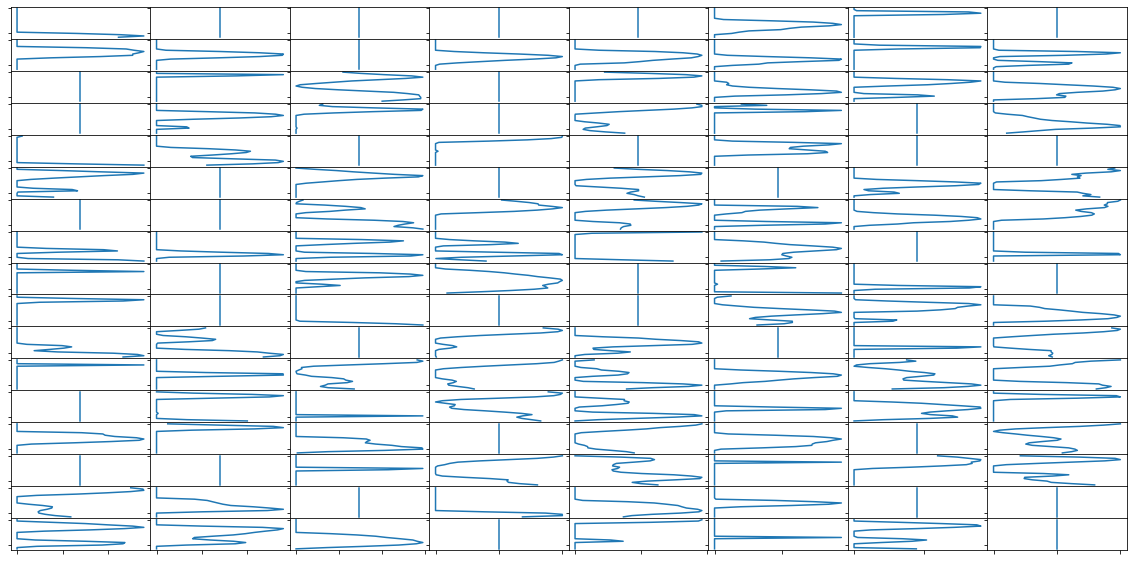

In [ ]:
k=1288
l=0
y=activations[l][k]
fig=plt.figure(figsize=(20,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,wspace=0, hspace=0)
for i in range(1,y.shape[1]+1):
  _size=y.shape[0]
  _num=y.shape[1]
  r=_num//8
  c=8
  fig.add_subplot(r,c,i)
  plt.plot(y[:,i-1],np.linspace(0,_size-1,_size),)
  plt.gca().invert_yaxis()
  plt.setp(plt.gca().get_xmajorticklabels(), visible=False)
  plt.setp(plt.gca().get_ymajorticklabels(), visible=False)

0 0


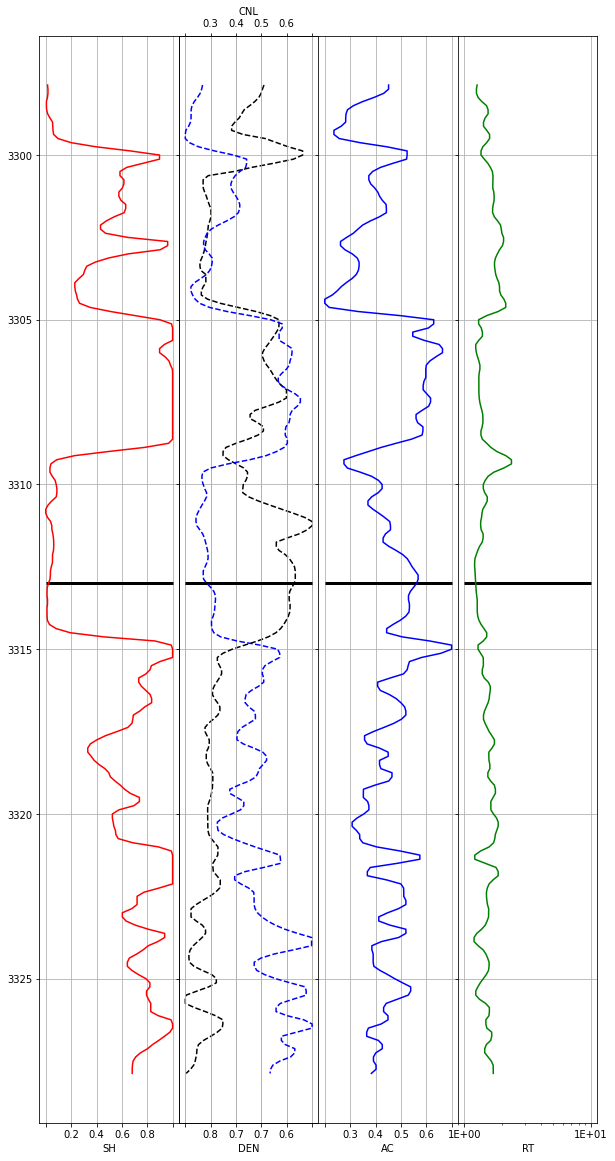

In [ ]:

print(np.argmax(y_train_CNN[k]),np.argmax(pred,axis=1)[k])
log_df=locate_log(x_train[k],df)
plot_log(log_df)

## 3.自定义损失函数

In [ ]:
def triplet_loss(y_true, y_pred):
    y_pred = K.l2_normalize(y_pred,axis=1)
    batch = batch_size
    #print(batch)
    ref1 = y_pred[0:batch,:]
    pos1 = y_pred[batch:batch+batch,:]
    neg1 = y_pred[batch+batch:3*batch,:]
    dis_pos = K.sum(K.square(ref1 - pos1), axis=1, keepdims=True)
    dis_neg = K.sum(K.square(ref1 - neg1), axis=1, keepdims=True)
    dis_pos = K.sqrt(dis_pos)
    dis_neg = K.sqrt(dis_neg)
    a1 = 17
    d1 = dis_pos + K.maximum(0.0, dis_pos - dis_neg + a1)
    return K.mean(d1)



def KLXent(y_true, y_pred,e=0.1):
  loss1 = K.categorical_crossentropy(y_true, y_pred)
  loss2 = K.categorical_crossentropy(K.ones_like(y_pred)/dim, y_pred)
  loss3 =tf.keras.losses.kullback_leibler_divergence(y_true, y_pred)
  return 0.5*(1-e)*loss1 + e*loss2+0.5*(1-e)*loss3


def myXent(y_true, y_pred):
  y_pred_pow =-K.log(K.pow(y_pred,y_pred))
  y_pred_max=K.max(y_true*y_pred,axis=1)
  k=1e-3
  M=tf.constant([
                     [1,        0,      k,     5000*k],
                     [0,        1,      k,   5000* k],
                     [k,  k,    1,    0],
                     [k,   k,    0,   1]
    ],dtype=tf.float32)
  out1=K.batch_dot(y_true@M,y_pred_pow)
  xent= K.categorical_crossentropy(y_true,y_pred)
  
  return K.flatten(out1)+(K.ones_like(y_pred_max)-y_pred_max)*xent

In [ ]:
y_true=K.constant([[0., 1., 0., 0.],[0., 0., 0., 1.]])
y_pred=K.constant([[0.01, 0.01, 0.97, 0.01],[0.7, 0.1, 0.1, 0.1]])
print(K.categorical_crossentropy(y_true,y_pred),'\n',myXent(y_true,y_pred))

tf.Tensor([4.6051702 2.3025851], shape=(2,), dtype=float32) 
 tf.Tensor([4.605246 2.303065], shape=(2,), dtype=float32)


Accuracy is 0.726000


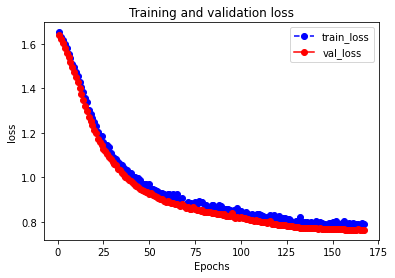

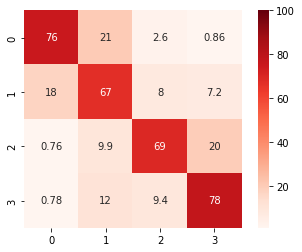

In [ ]:
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5)
lr_adjust=callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.3,patience=3)
callbacks_list = [early_stop, lr_adjust]
model_dense=simpleNN(48,18,loss=myXent)
model_dense,history=simple_train(200,7,model_dense,x_train,y_train, x_test,y_test,callbacks_list)
scores =  history.history['val_accuracy']
print('Accuracy is %1f' %  scores[-1] )
plot_metric(history,'loss')
plot_est_obs(np.argmax(y_test,axis=1),model_dense.predict(x_test))

In [ ]:
num_folds =4
kfold = KFold(n_splits=num_folds, shuffle=True)
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5)
lr_adjust=callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.3,patience=3)
callbacks_list = [early_stop, lr_adjust]
neu1,neu2,bs=48,18,7
acc_norm=1-kfold_val(neu1,neu2,bs,callbacks_list)
acc_myXent=1-kfold_val(neu1,neu2,bs,callbacks_list,loss=myXent)
acc_KLXent=1-kfold_val(neu1,neu2,bs,callbacks_list,loss=KLXent)


[48, 18, 7, 0.722]
[48, 18, 7, 0.7]
[48, 18, 7, 0.722]


In [ ]:
win=12
ker=16
#CNN
num_folds =4
early_stop = callbacks.EarlyStopping(monitor="val_loss", patience=8,min_delta=0.001)
lr_adjust = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=4)
# tb = keras.callbacks.TensorBoard(log_dir='log',histogram_freq=2)
callbacks_list = [early_stop, lr_adjust]
acc_norm=1-kfold_val_CNN(win,ker,7,callbacks_list)
acc_myXent=1-kfold_val_CNN(win,ker,7,callbacks_list,loss=myXent)
acc_KLXent=1-kfold_val_CNN(win,ker,7,callbacks_list,loss=KLXent)



...............................................................................0.9730639457702637


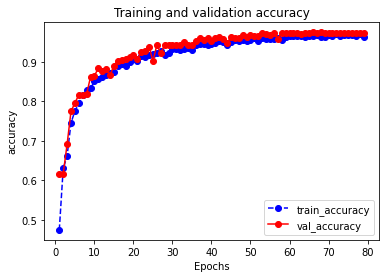

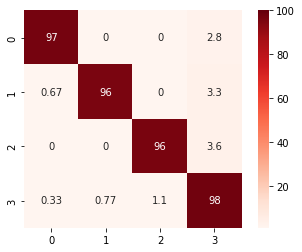

In [ ]:
x_data_CNN, y_data_CNN = roll_log(df.loc[(SLB_wells,),:], win)

# 分组抽样
# x_data_CNN.shape
sample_y=pd.DataFrame(y_data_CNN,columns=['CJJS'])
sample_y=sample_y[sample_y['CJJS']<9]
sample_y.groupby(['CJJS'],as_index = False).apply(lambda x: x.sample(n=sample_n, replace=False, random_state=666))
index = sample_y.index.get_level_values(0)
x_data_CNN =x_data_CNN[index]
x_data_CNN = x_data_CNN.swapaxes(1,2)
y_data_CNN = y_data_CNN[index]
y_data_CNN= K.one_hot(y_data_CNN,dim).numpy()
x_train_CNN, x_test_CNN , y_train_CNN, y_test_CNN = train_test_split(x_data_CNN, y_data_CNN, test_size = 0.25)

early_stop = callbacks.EarlyStopping(monitor="val_loss", patience=8,min_delta=0.001)
lr_adjust = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=4)
# tb = keras.callbacks.TensorBoard(log_dir='log',histogram_freq=2)
callbacks_list = [early_stop, lr_adjust,PrintDot()]

model_CNN = CNN(win,ker,loss=myXent)
model_CNN,history=simple_train(150,7,model_CNN,x_train_CNN,y_train_CNN,x_test_CNN,y_test_CNN,callbacks_list)
scores =  history.history['val_accuracy'][-1]
print(scores)
plot_metric(history,'accuracy')
plot_est_obs(np.argmax(y_test_CNN,axis=1),model_CNN.predict(x_test_CNN))

## #4. 自训练网络

In [ ]:
def self_train(init_mdl,x_data, y_data, x_unlab,y_unlab=None):
  x_train, x_test , y_train, y_test = train_test_split(x_data, y_data, test_size = 0.25)
  # Initiate iteration counter
  iterations = 0

  # Containers to hold scores and # of pseudo-labels
  train_acc = []
  test_acc = []
  pseudo_labels = []

  # Assign value to initiate while loop
  high_prob = [1]*100 

  # Loop will run until there are no more high-probability pseudo-labels
  while len(high_prob) >= 100:
    mdl2=CNN(12,16)    
      # Fit classifier and make train/test predictions
    mdl2,history=simple_train(150,7,mdl2,x_train, y_train,x_test ,  y_test ,callbacks_list)

    y_hat_train = np.argmax(mdl2.predict(x_train),axis=1)
    y_hat_test = np.argmax(mdl2.predict(x_test),axis=1)
    if iterations==0:
      plot_est_obs(y_test,mdl2.predict(x_test))
    # Calculate and print iteration # and scores, and store scores
    train_accuracy = accuracy_score(y_train, y_hat_train)
    test_accuracy = accuracy_score(y_test, y_hat_test)
    print(f"Iteration {iterations}")
    print(f"Train acc: {train_accuracy}")
    print(f"Test acc: {test_accuracy}")
    train_acc.append(train_accuracy)
    test_acc.append(test_accuracy)
  
    # Generate predictions and probabilities for unlabeled data
    print(f"Now predicting labels for unlabeled data...")

    pred_probs = mdl2.predict(x_unlab)
    # pred_probs=np.mean(np.array([pred_probs, cat_2_proba(y_unlab,4,0.9)]), axis=0 )
    preds = np.argmax(pred_probs,axis=1).T
    prob_max = pred_probs.max(axis=1).T
    

    # Store predictions and probabilities in dataframe
    df_pred_prob = pd.DataFrame([])
    df_pred_prob['preds'] = preds
    df_pred_prob['prob_max'] = prob_max
    # df_pred_prob.index = x_unlab.index
    
    # Separate predictions with > 99% probability
    high_prob = df_pred_prob.loc[df_pred_prob['prob_max'] > 0.999]
    print(f"{len(high_prob)} high-probability predictions added to training data.")
    
    pseudo_labels.append(len(high_prob))

    # Add pseudo-labeled data to training data
    x_train = np.vstack([x_train, x_unlab[high_prob.index]])
    y_train = np.hstack([y_train, high_prob.preds.T])      
    
    # Drop pseudo-labeled instances from unlabeled data
    x_unlab = np.delete(x_unlab,high_prob.index,0)
    y_unlab= np.delete(y_unlab,high_prob.index,0)
    print(f"{len(x_unlab)} unlabeled instances remaining.\n")
    
    # Update iteration counter
    iterations += 1
  return mdl2
def cat_2_proba(a: np.array,cat_num:int,proba_true):
  proba=np.zeros(a.shape[0]*cat_num).reshape(a.shape[0],cat_num)
  ind=[range(0,a.shape[0]),list(a.astype(int))]
  proba[ind]=proba_true
  proba=np.where(proba>0,proba,(1-proba_true)/(cat_num-1))
  return proba

Iteration 0
Train acc: 0.9894500561167228
Test acc: 0.9757575757575757
Now predicting labels for unlabeled data...
441 high-probability predictions added to training data.
1265 unlabeled instances remaining.

Iteration 1
Train acc: 0.9906045751633987
Test acc: 0.9730639730639731
Now predicting labels for unlabeled data...
245 high-probability predictions added to training data.
1020 unlabeled instances remaining.

Iteration 2
Train acc: 0.9570122544252091
Test acc: 0.9488215488215488
Now predicting labels for unlabeled data...
15 high-probability predictions added to training data.
1005 unlabeled instances remaining.



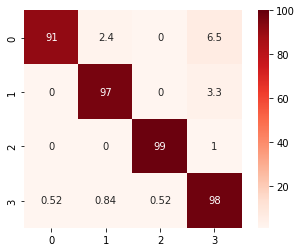

In [ ]:
win=12
ker=16
x_data_CNN, y_data_CNN = roll_log(df.loc[(SLB_wells,),:], win)
temp=df.loc[(PCOC_wells,),:]
x_PCOC, y_PCOC = roll_log(temp[temp['CJJS']<9], win)
ind=np.argwhere(y_PCOC==3)[:,0]
ind=np.random.choice(ind,5700,replace=False)
y_PCOC=np.delete(y_PCOC,ind,axis=0)
x_PCOC=np.delete(x_PCOC,ind,axis=0)
x_PCOC=x_PCOC.swapaxes(1,2)
# 分组抽样
# x_data_CNN.shape
sample_y=pd.DataFrame(y_data_CNN,columns=['CJJS'])
sample_y=sample_y[sample_y['CJJS']<9]
sample_y.groupby(['CJJS'],as_index = False).apply(lambda x: x.sample(n=sample_n, replace=False, random_state=666))
index = sample_y.index.get_level_values(0)
x_data_CNN =x_data_CNN[index]
x_data_CNN = x_data_CNN.swapaxes(1,2)
y_data_CNN = y_data_CNN[index]

early_stop = callbacks.EarlyStopping(monitor="val_loss", patience=8,min_delta=0.001)
lr_adjust = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=4)
callbacks_list = [early_stop, lr_adjust]
mod = CNN(win,ker)
mod=self_train(mod,x_data_CNN,y_data_CNN,x_PCOC,y_PCOC)


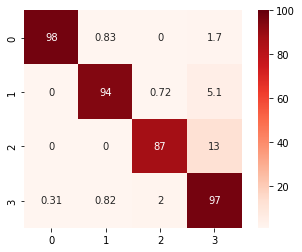

In [ ]:
plot_est_obs(y_test,mod.predict(x_test))

In [ ]:
a=y_PCOC
b=y_PCOC*3
np.bincount(np.mean( np.array([ a, b ]), axis=0 ).astype(int))

array([ 404,    0,  628,    0,  131,    0, 6243])

一个全连接+一个卷积网络合成输出

# V #TODO 深度置信网络

In [ ]:
#!/usr/bin/env python

"""
Using MNIST, compare classification performance of:
1) logistic regression by itself,
2) logistic regression on outputs of an RBM, and
3) logistic regression on outputs of a stacks of RBMs / a DBN.
"""
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import BernoulliRBM
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report


def norm(arr):
    arr = arr.astype(np.float)
    arr -= arr.min()
    arr /= arr.max()
    return arr


if __name__ == '__main__':

    X = x_data
    Y = y_data

    # split into train, validation, and test data sets
    X_train, X_test, Y_train, Y_test = train_test_split(X,       Y,       test_size=0.2, random_state=0)
    X_train, X_val,  Y_train, Y_val  = train_test_split(X_train, Y_train, test_size=0.125, random_state=0)

    #                                         
    # set hyperparameters

    learning_rate = 0.6 # from Erhan et el. (2010): median value in grid-search
    total_units   =  500 
    total_epochs  =  50
    batch_size    =  128

    C = 200

    # TODO optimize using grid search, etc

    #                                         
    # construct models

    # RBM
    rbm = BernoulliRBM(n_components=total_units, learning_rate=learning_rate, batch_size=batch_size, n_iter=total_epochs, verbose=0)

    # # "output layer"
    logistic = LogisticRegression(C=C, solver='lbfgs', multi_class='multinomial', max_iter=2000, verbose=0)

    models = []
    models.append(Pipeline(steps=[('logistic', clone(logistic))]))                                              # base model / benchmark
    models.append(Pipeline(steps=[('rbm1', clone(rbm)), ('logistic', clone(logistic))]))                        # single RBM
    models.append(Pipeline(steps=[('rbm1', clone(rbm)), ('rbm2', clone(rbm)), ('logistic', clone(logistic))]))  # RBM stack / DBN

    #                                         
    # train and evaluate models

    for model in models:
        # train
        model.fit(X_train, Y_train)

        # evaluate using validation set
        print("Model performance:\n%s\n" % (
            classification_report(Y_val, model.predict(X_val))))

    # TODO: after parameter optimization, evaluate on test set

Model performance:
              precision    recall  f1-score   support

           0       0.78      0.78      0.78        49
           1       0.76      0.79      0.77        52
           2       0.86      0.67      0.75         9

    accuracy                           0.77       110
   macro avg       0.80      0.74      0.77       110
weighted avg       0.77      0.77      0.77       110


Model performance:
              precision    recall  f1-score   support

           0       0.45      1.00      0.62        49
           1       0.00      0.00      0.00        52
           2       0.00      0.00      0.00         9

    accuracy                           0.45       110
   macro avg       0.15      0.33      0.21       110
weighted avg       0.20      0.45      0.27       110


Model performance:
              precision    recall  f1-score   support

           0       0.45      1.00      0.62        49
           1       0.00      0.00      0.00        52
           2    

In [ ]:
#1.创建writer，写日志文件
writer=tf.summary.FileWriter('logs', tf.get_default_graph())
 
#2.保存日志文件
writer.close()
 
#3.运行可视化命令，启动服务




AttributeError: module 'tensorboard.summary._tf.summary' has no attribute 'FileWriter'